## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
Los conjuntos de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.
Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está muy desequilibrado: la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene sólo variables de entrada numéricas que son el resultado de una transformación PCA. Lamentablemente, debido a cuestiones de confidencialidad, no podemos proporcionar las características originales ni más información general sobre los datos. Las características V1, V2,… V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Monto' es el monto de la transacción; esta característica se puede utilizar para el aprendizaje sensible al costo, por ejemplo. La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv


### Librerias

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np

In [75]:
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

In [76]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## 1. Lectura del conjunto de datos

In [77]:
df = pd.read_csv("datasets/creditcard.csv")

## 2. Visualización del conjunto de datos

In [78]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [79]:
# 492=transacciones fraudulentas
# 284315=transacciones legitimas
# El conjunto de datos se encuntra desequilibrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [80]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [81]:
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

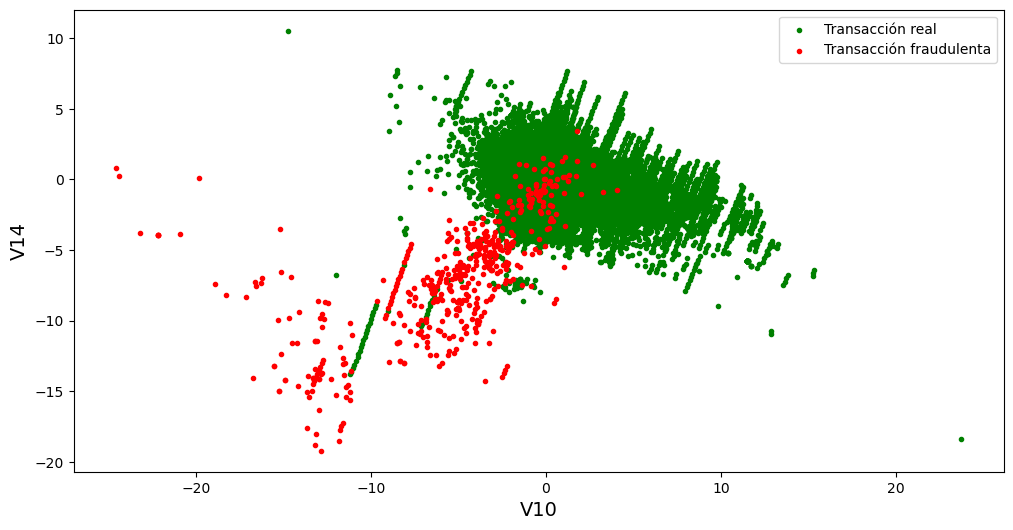

In [82]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".", label="Transacción real")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".", label="Transacción fraudulenta")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.legend()
plt.show()

## 3. Preparación del conjunto de datos

In [83]:
#Eliminados los datos que no estan normalizados.
df = df.drop(["Time", "Amount"], axis=1)

## 4. Kmeans con un conjunto de datos de dos dimensiones

In [84]:
X = df[["V10", "V14"]].copy()
X

,V10,V14
0,0.090794,-0.311169
1,-0.166974,-0.143772
2,0.207643,-0.165946
3,-0.054952,-0.287924
4,0.753074,-1.119670
...,...,...
284802,4.356170,4.626942
284803,-0.975926,-0.675143
284804,-0.484782,-0.510602
284805,-0.399126,0.449624


In [88]:
# Generamos los clusters para nuestro conjunto de datos sin etiquetar
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init=10 ,random_state=42)
clusters = kmeans.fit_predict(X)

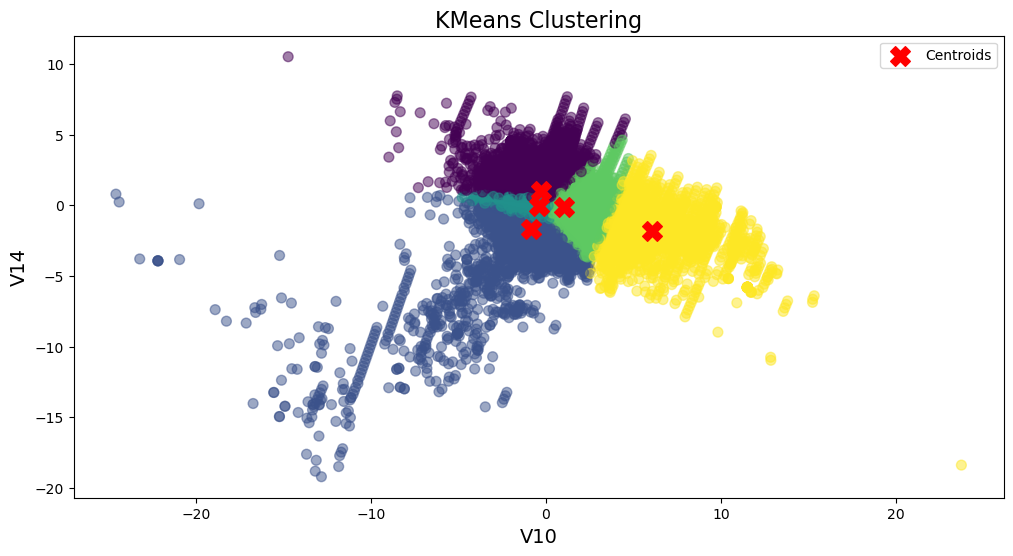

In [89]:
# Graficar los resultados de KMeans
plt.figure(figsize=(12, 6))
plt.scatter(X["V10"], X["V14"], c=clusters, cmap='viridis', s=50, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.title("KMeans Clustering", fontsize=16)
plt.legend()
plt.show()

In [90]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df['Class'] == 1].tolist())

for key in sorted(counter.keys()):
    print("Etiqueta {0} tiene {1} muestras - {2} son muestras maliciosas.".format(
        key, counter[key], bad_counter[key]))

Etiqueta 0 tiene 65142 muestras - 12 son muestras maliciosas.
Etiqueta 1 tiene 27352 muestras - 449 son muestras maliciosas.
Etiqueta 2 tiene 120154 muestras - 16 son muestras maliciosas.
Etiqueta 3 tiene 69723 muestras - 14 son muestras maliciosas.
Etiqueta 4 tiene 2436 muestras - 1 son muestras maliciosas.


## 5. Kmeans con un conjunto de datos multidimensional

In [91]:
X = df.drop("Class", axis=1)
y = df["Class"].copy()

In [95]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init=10,random_state=42)
clusters = kmeans.fit_predict(X)

In [96]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Etiqueta {0} tiene {1} muestras - {2} son muestras maliciosas.".format(
        key, counter[key], bad_counter[key]))

Etiqueta 0 tiene 97604 muestras - 138 son muestras maliciosas.
Etiqueta 1 tiene 3566 muestras - 12 son muestras maliciosas.
Etiqueta 2 tiene 45512 muestras - 2 son muestras maliciosas.
Etiqueta 3 tiene 131987 muestras - 137 son muestras maliciosas.
Etiqueta 4 tiene 6138 muestras - 203 son muestras maliciosas.


### Aplicamos selección de características con _Random Forest_

In [97]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [100]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [101]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()

In [102]:
X_reduced

,V17,V14,V16,V12,V10,V11,V18
0,0.207971,-0.311169,-0.470401,-0.617801,0.090794,-0.551600,0.025791
1,-0.114805,-0.143772,0.463917,1.065235,-0.166974,1.612727,-0.183361
2,1.109969,-0.165946,-2.890083,0.066084,0.207643,0.624501,-0.121359
3,-0.684093,-0.287924,-1.059647,0.178228,-0.054952,-0.226487,1.965775
4,-0.237033,-1.119670,-0.451449,0.538196,0.753074,-0.822843,-0.038195
...,...,...,...,...,...,...,...
284802,1.991691,4.626942,1.107641,2.711941,4.356170,-1.593105,0.510632
284803,-0.025693,-0.675143,-0.711757,0.915802,-0.975926,-0.150189,-1.221179
284804,0.313502,-0.510602,0.140716,0.063119,-0.484782,0.411614,0.395652
284805,0.509928,0.449624,-0.608577,-0.962886,-0.399126,-1.933849,1.113981


### Entrenamiento de KMEANS con el conjunto de datos reducido

In [104]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init= 10,random_state=42)
clusters = kmeans.fit_predict(X_reduced)

In [105]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Etiqueta {0} tiene {1} muestras - {2} son muestras maliciosas.".format(
        key, counter[key], bad_counter[key]))

Etiqueta 0 tiene 100991 muestras - 87 son muestras maliciosas.
Etiqueta 1 tiene 46785 muestras - 20 son muestras maliciosas.
Etiqueta 2 tiene 20163 muestras - 45 son muestras maliciosas.
Etiqueta 3 tiene 116558 muestras - 73 son muestras maliciosas.
Etiqueta 4 tiene 310 muestras - 267 son muestras maliciosas.


## 6. Evaluación de los resultados

Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.

In [106]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y, clusters))

Purity Score: 0.9990590118922639


In [107]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))

Shiloutte:  0.17490197108736494


In [108]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  40536.787344940625
